## Sampling from a Gaussian process:

ipykernel_launcher.py:61: RuntimeWarning: covariance is not positive-semidefinite.


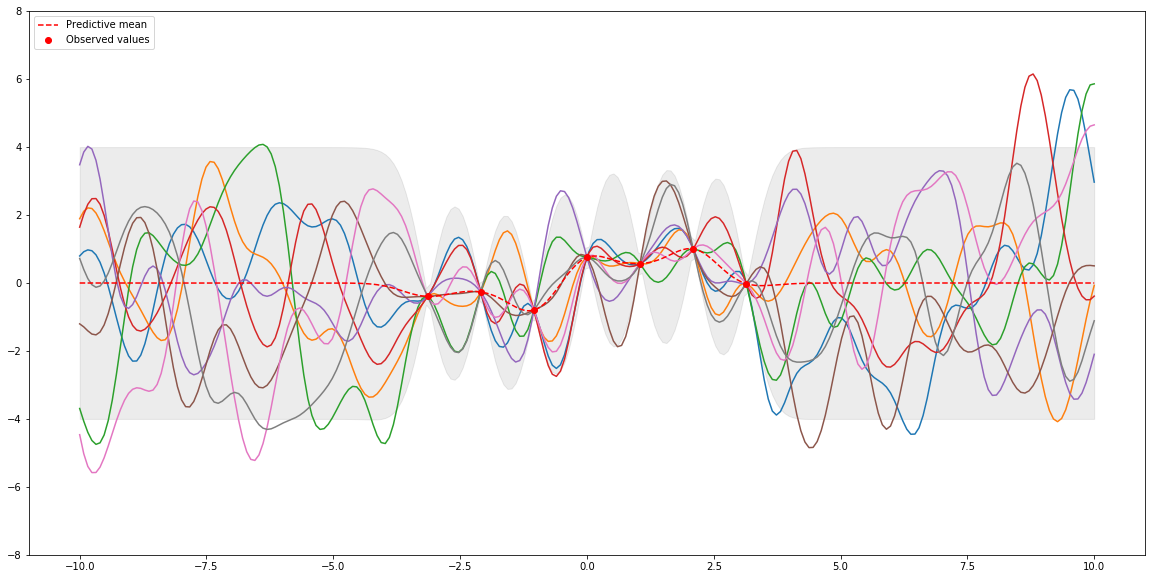

In [3]:
import pylab as pb
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from math import pi, sqrt
from numpy.random import normal, multivariate_normal

N = 250 # Number of samples x
N_func = 8 # Number of function samples
sigma = 2 # Hyperparameter for the kernel
l = 0.7 # Hyperparameter for the kernel
sigma2 = 0 # Hyperparameter for the GP predictive distribution

def kernel(x1, x2, sigma, l):
    """
    Squared exponential kernel
    """
    return (sigma ** 2) * np.exp((x1-x2).T*(x1-x2)*(-1/(l**2)))

def sample_x(start=-10, to=-10, samples=50):
    """
    Returns column vector with samples from the interval equally spaced out
    """
    return np.linspace(start, to, samples).reshape(-1, 1) # x as a column vector

def K(x, x_prime, kernel):
    """
    Builds the covariance matrix from x, x_prime and the kernel function
    x and x_prime are column vectors, kernel is the kernel function
    """
    N, M = x.shape[0], x_prime.shape[0]
    K = np.zeros((N, M), dtype=np.float32)
    for i in range(N):
        for j in range(M):
            K[i, j] = kernel(x[i], x_prime[j])
    return K

def sample_sine(x):
    """
    x is a column vector
    Returns samples of the sine function at the x points with noise
    """
    N = x.shape[0]
    y = np.sin(x)
    # Now add some noise
    for i in range(N):
        y[i] += normal(0, sqrt(0.5)) # Second argument is the STD
    return y

def gp_predictive_distribution_sample(x, x_prime, y, kernel, sigma, samples=1):
    """
    x, x_prime and y are column vectors
    kernel is the kernel function
    sigma is the hyperparameter for the noise in the observed values
    samples is the number of functions to sample
    """
    sigma_identity = (sigma**2)*np.identity(x.shape[0])
    kxx_sigma_inverse = np.linalg.inv(K(x, x, kernel)+sigma_identity)
    mean_vector = K(x_prime, x, kernel).dot(kxx_sigma_inverse).dot(y).flatten()
    covariance_matrix = K(x_prime, x_prime, kernel)-K(x_prime, x, kernel).dot(kxx_sigma_inverse).dot(K(x, x_prime, kernel))
    gp_predictive_dist_sample = multivariate_normal(mean_vector, covariance_matrix, size=(samples,))
    
    K_trans = K(x_prime, x, kernel)
    variance = K(x_prime,x_prime,kernel).diagonal()-np.einsum("ij,ij->i",np.dot(K_trans,np.linalg.inv(K(x,x,kernel))),K_trans)
    variance[variance < 0] = 0.0
    return gp_predictive_dist_sample, mean_vector, np.sqrt(variance)

def combine_observed_with_predicted(x, x_prime, y, predictions):
    """
    Combines the observed and predicted function values
    x, y and x_prime are column vectors
    predictions is a matrix with a row containing function samples at every point in x_prime
    """
    x_combined = np.vstack((x, x_prime)) # Put x and x_prime in a column vector
    y_tile = np.tile(y.reshape(1, -1), (predictions.shape[0], 1)) # Copy the observed y several times
    y_combined = np.hstack((y_tile, predictions))
    y_combined_sorted = np.zeros(shape=y_combined.shape, dtype=np.float32)
    for i in range(predictions.shape[0]):
        y_row = y_combined[i]
        x_combined_sorted, y_sorted = zip(*sorted(zip(x_combined, y_row)))
        y_combined_sorted[i] = np.array(y_sorted)            
    return x_combined_sorted, y_combined_sorted

def visualise_samples(x, y):
    """
    x is a column vector with the values at which the functions are sampled at
    y is a matrix with every row being a sampled function at the x points
    """
    num_samples = y.shape[0]
    for i in range(num_samples):
        plt.plot(x, y[i]) # Plot sampled function

x = sample_x(-pi, pi, 7) # x as a column vector
y = sample_sine(x) # y as a column vector
x_prime = sample_x(-10, 10, N)
kernel_f = partial(kernel, sigma=sigma, l=l) # Partially apply hyperparameters
predictions, mean, std = gp_predictive_distribution_sample(x, x_prime, y, kernel_f, sigma2, N_func)
#combined_x, combined_y = combine_observed_with_predicted(x, x_prime, y, predictions)

# Everything's computed, time to draw some fancy stuff
plt.figure(figsize=(20,10)) # Plot dimensions
plt.ylim(-8,8) # Set range for y values
visualise_samples(x_prime, predictions) # Plot function predictions
predictive_mean, = plt.plot(x_prime, mean, 'r--', label='Predictive mean') # Plot the mean
observed_vals, = plt.plot(x, y, 'ro', label='Observed values') # Plot the observed values
plt.fill_between(x_prime.flatten(), mean-2*std, mean+2*std, alpha=0.075, color='k') # Plot the std
plt.legend(handles=[predictive_mean, observed_vals], loc='upper left')
pb.savefig("q14_lsc_{}_sigma_{}_sigma2_{}.png".format(l, sigma, sigma2), bbox_inches='tight')
plt.show()